In [ ]:
### Import Libraries

import os
import zipfile
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, RandomRotation, RandomFlip, RandomZoom, RandomTranslation, Rescaling, SeparableConv2D
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.utils import image_dataset_from_directory
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
### Download dataset from Kaggle

! pip install -q kaggle
! mkdir ~/.kaggle

os.environ['KAGGLE_USERNAME'] = 'jcliverpool'
os.environ['KAGGLE_KEY'] = '0789b79f53a13e32e0cd4a38847c2b3c'

In [ ]:
! kaggle datasets download paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:46<00:00, 20.0MB/s]
100% 2.29G/2.29G [01:46<00:00, 23.0MB/s]


Unzip Dataset

In [ ]:
### Unzip Dataset
test_data_path = 'chest_xray/test'
train_data_path = 'chest_xray/train'
val_data_path = 'chest_xray/val'
folder_to_extract = [test_data_path, train_data_path, val_data_path]

with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zObject:
  for file in zObject.namelist():
    for pathname in folder_to_extract:
      if file.startswith(pathname):
        zObject.extract(file)

Dataset distribution

Number of images in train dataset
Total: 5216
NORMAL: 1341 (25.71%)
PNEUMONIA: 3875 (74.29%)
bias in ratio of normal to pneumonia image: 0.35


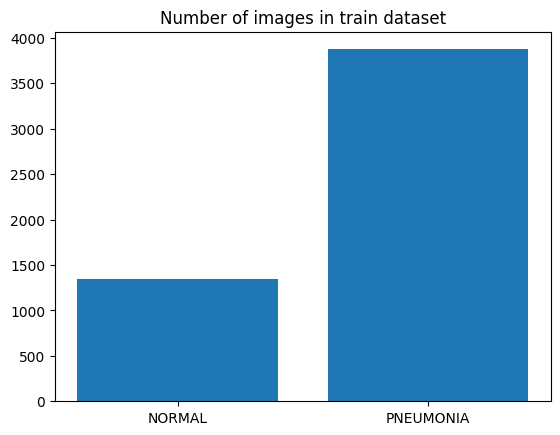

Number of images in test dataset
Total: 624
NORMAL: 234 (37.50%)
PNEUMONIA: 390 (62.50%)
bias in ratio of normal to pneumonia image: 0.60


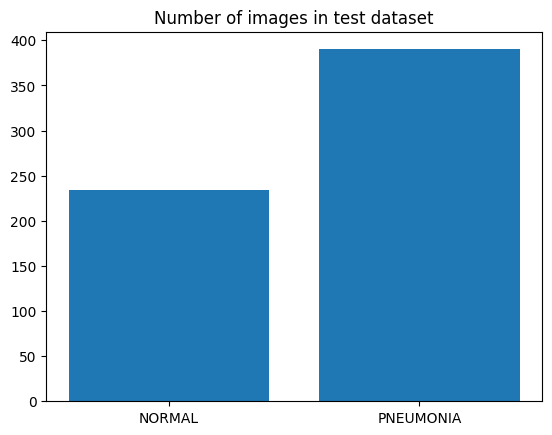

Number of images in val dataset
Total: 16
NORMAL: 8 (50.00%)
PNEUMONIA: 8 (50.00%)
bias in ratio of normal to pneumonia image: 1.00


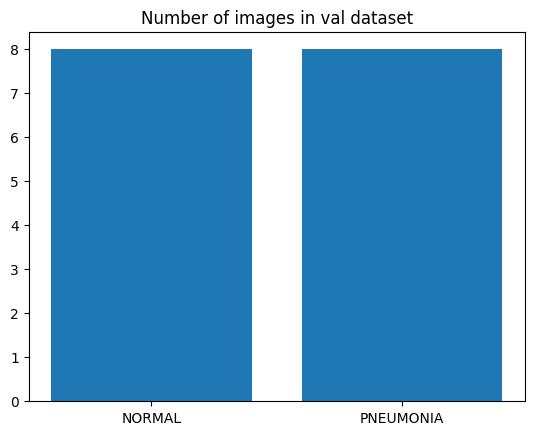

In [ ]:
data_labels = ['NORMAL', 'PNEUMONIA']
def data_class_analysis(data_dir, title='Number of images in dataset'):
    print(title)
    counts = [0] * len(data_labels)
    ratios = {}
    dataset_count = sum([len(files) for root, dirs, files in os.walk(data_dir)])
    print(f'Total: {dataset_count}')

    for i in range(len(data_labels)):
      label = data_labels[i]
      counts[i] = len(os.listdir(os.path.join(data_dir, label)))
      ratios[label] = counts[i]/dataset_count
      print(f'{label}: {counts[i]} ({ratios[label]*100:.2f}%)')

    print(f'bias in ratio of normal to pneumonia image: {counts[0]/counts[1]:.2f}')
    plt.title(title)
    plt.bar(data_labels, counts)
    plt.show()
    return dataset_count, ratios

train_data_counts, train_data_class_ratios = data_class_analysis(train_data_path, 'Number of images in train dataset')
test_data_counts, test_data_class_ratios = data_class_analysis(test_data_path, 'Number of images in test dataset')
val_data_counts, val_data_class_ratios = data_class_analysis(val_data_path, 'Number of images in val dataset')

train: 5216 (89.07%)
test: 624 (10.66%)
val: 16 (0.27%)


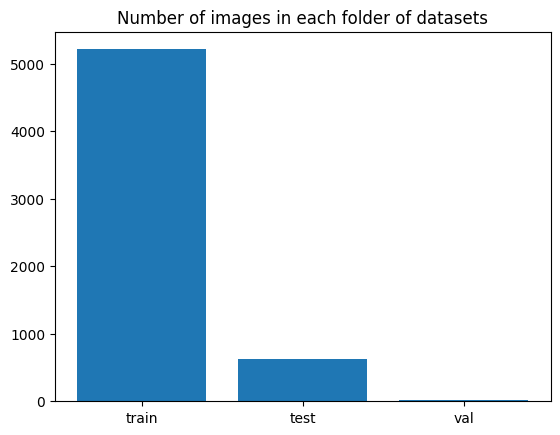

In [ ]:
##### Distribution across Datasets
dataset_label = ['train', 'test', 'val']
data_counts = [train_data_counts, test_data_counts, val_data_counts]
total_data_count = sum(data_counts)

def count_data_by_dataset(label, counts):
    for i in range(len(label)):
        print(f'{label[i]}: {counts[i]} ({counts[i]/total_data_count*100:.2f}%)')

    plt.title('Number of images in each folder of datasets')
    plt.bar(label, counts)
    plt.show()


count_data_by_dataset(dataset_label, data_counts)

Training dataset is bias to pneumonia adjustment which in result dataset imbalance, it is required to handle dataset imbalance by applying Class weight adjustment and Data Augmentation

In [ ]:
###Class Weight Adjustment

normal_image_weight = 1/train_data_class_ratios['NORMAL']/2
pneumonia_image_weight = 1/train_data_class_ratios['PNEUMONIA']/2

class_weight = {0: normal_image_weight, 1: pneumonia_image_weight}
print(f'Class weight: {class_weight}')

Class weight: {0: 1.9448173005219984, 1: 0.6730322580645162}


In [ ]:
###Load Data and Class Labels

batch_size = 32
image_size = 256

train_dataset = image_dataset_from_directory(train_data_path,
        color_mode='grayscale',
        batch_size=batch_size,
        image_size=(image_size,image_size),
        shuffle=True,
        )

val_dataset = image_dataset_from_directory(val_data_path,
        color_mode='grayscale',
        batch_size=batch_size,
        image_size=(image_size,image_size),
        shuffle=False,
        )

class_names = train_dataset.class_names
print(class_names)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
['NORMAL', 'PNEUMONIA']


In [ ]:
###Inspecting the Training Dataset

train_images, train_labels = next(train_dataset.as_numpy_iterator())
print(f'Image batch shape: {train_images.shape}, label batch shape: {train_labels.shape}')
print(f'Image value min: {train_images.min()}, max: {train_images.max()}')

Image batch shape: (32, 256, 256, 1), label batch shape: (32,)
Image value min: 0.0, max: 255.0


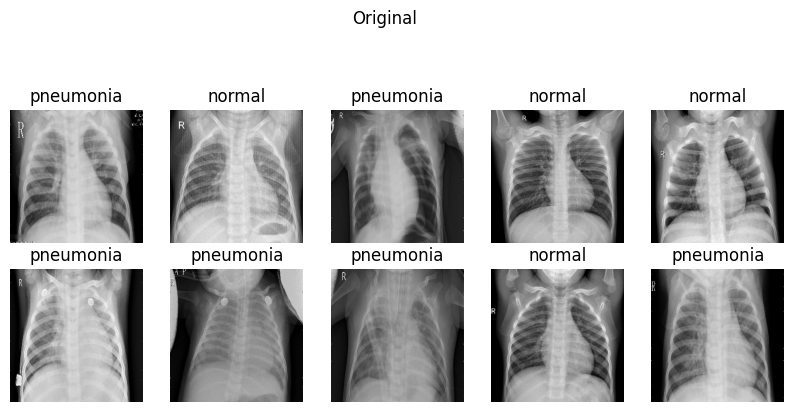

In [ ]:
def visualize_images(dataset, title, row=1, col=5):
  plt.figure(figsize=(10,10)).suptitle(title)
  for images, labels in dataset.take(1):
    for i in range(row * col):
      ax = plt.subplot(5, 5, i + 1)
      plt.imshow(images[i].numpy(), cmap='gray')
      plt.title(class_names[labels[i].numpy()].lower())
      plt.axis("off")

visualize_images(train_dataset,'Original',2)

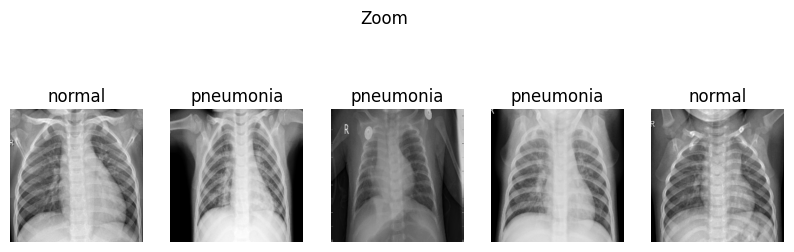

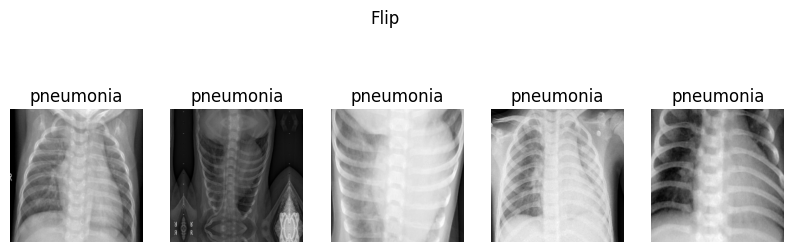

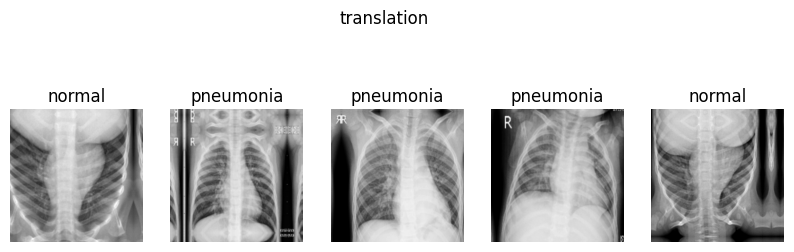

In [ ]:
## Data Augmentation

def preprocess_dataset(dataset, layer):
  processed_dataset = dataset.map(lambda x, y: (layer(x), y))
  return processed_dataset

zoom = RandomZoom(0.3)
train_dataset = preprocess_dataset(train_dataset, zoom)
visualize_images(train_dataset,'Zoom')

flip = RandomFlip("vertical")
train_dataset = preprocess_dataset(train_dataset, flip)
visualize_images(train_dataset, 'Flip')

translation = tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1)
train_dataset = preprocess_dataset(train_dataset, translation)
visualize_images(train_dataset,'translation')

Normalize dataset before building model

In [ ]:
rescaling = Rescaling(1./255)
train_dataset = preprocess_dataset(train_dataset, rescaling)
train_images, train_labels = next(train_dataset.as_numpy_iterator())
print(f'Image batch shape: {train_images.shape}, label batch shape: {train_labels.shape}')
print(f'Image value after scaling min: {train_images.min()}, max: {train_images.max()}')

val_dataset = preprocess_dataset(val_dataset, rescaling)

Image batch shape: (32, 256, 256, 1), label batch shape: (32,)
Image value after scaling min: 0.0, max: 0.9999794960021973


CNN Model Building

In [ ]:
def build_model(stride, padding, activation):
    strides = (stride, stride)
    maxpool_padding = 'valid'
    if stride != 1:
        maxpool_padding = 'same'

    model = Sequential()

    # First Convolutional Block
    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1),
                     padding='same', activation=activation,
                     input_shape=(256, 256, 1)))
    model.add(MaxPool2D(pool_size=(2, 2), padding='same'))

    # Second Convolutional Block
    model.add(SeparableConv2D(filters=64, kernel_size=(3, 3),
                             strides=strides, padding='same',
                             activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), padding='same'))

    # Third Convolutional Block
    model.add(SeparableConv2D(filters=128, kernel_size=(3, 3),
                             strides=strides, padding='same',
                             activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.2))

    # Fourth Convolutional Block
    model.add(SeparableConv2D(filters=256, kernel_size=(3, 3),
                             strides=strides, padding='same',
                             activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.2))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(units=512, activation=activation))
    model.add(Dropout(0.5))
    model.add(Dense(units=128, activation=activation))
    model.add(Dense(units=1, activation='sigmoid'))

    return model

Model Training

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## Hyperparameter Grid
stride_set = [1, 2]
padding_set = ['same']  # Removed 'valid' padding to prevent dimension issues
activation_set = ['relu', 'sigmoid']
model_shape = train_images.shape
models_accuracy = {}
# Get input shape from dataset
model_shape=train_images.shape
models_accuracy={}

def get_filename(stride,padding,activation):
  return f'model-{stride}-{padding}-{activation}'

def get_filepath(filename):
    return f'model/{filename}.keras'

In [ ]:
def plot_history(history, title):
  fig, ax = plt.subplots(1, 2, figsize = (8, 4))
  fig.suptitle(title)
  ax = ax.ravel()

  for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(history[metric])
    ax[i].plot(history['val_' + metric])
    ax[i].set_title('Model {}'.format(metric))
    ax[i].set_xlabel('Number of epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])

In [ ]:
def train_model(shape, stride, padding, activation):
    filename = get_filename(stride, padding, activation)
    print(f'Training model {filename} with stride {stride}, padding {padding} and activation {activation}')
    filepath = get_filepath(filename)

    # Create and compile model
    model = build_model(stride, padding, activation)
    model.compile(optimizer="rmsprop",
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

    # Callbacks
    lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.3,
                                 patience=2,
                                 verbose=1,
                                 mode='max')
    checkpoint = ModelCheckpoint(filepath=filepath,
                               save_best_only=True,
                               save_weights_only=False)

    # Train model
    model_training = model.fit(train_dataset,
                             epochs=12,
                             validation_data=val_dataset,
                             callbacks=[checkpoint, lr_reduce],
                             class_weight=class_weight)

    models_accuracy[filename] = model_training.history['accuracy'][np.argmin(model_training.history['loss'])]
    plot_history(model_training.history, filename)


Training model model-1-same-relu with stride 1, padding same and activation relu


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 309ms/step - accuracy: 0.7428 - loss: 5.3478 - val_accuracy: 0.5000 - val_loss: 1.7210 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 31s 66ms/step - accuracy: 0.8549 - loss: 0.3150 - val_accuracy: 0.5000 - val_loss: 1.6437 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.8724 - loss: 0.3026 - val_accuracy: 0.5000 - val_loss: 3.6722 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.8966 - loss: 0.2550 - val_accuracy: 0.5000 - val_loss: 5.2567 - learning_rate: 0.0010
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.9054 - loss: 0.2466 - val_accuracy: 0.5000 - val_loss: 7.8875 - learning_rate: 0.0010
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.9149 - loss: 0.2073 - val_accuracy: 0.6250 - val_loss: 2.5909 - learning_rate: 0.0010
Epoch 7/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9258 - los

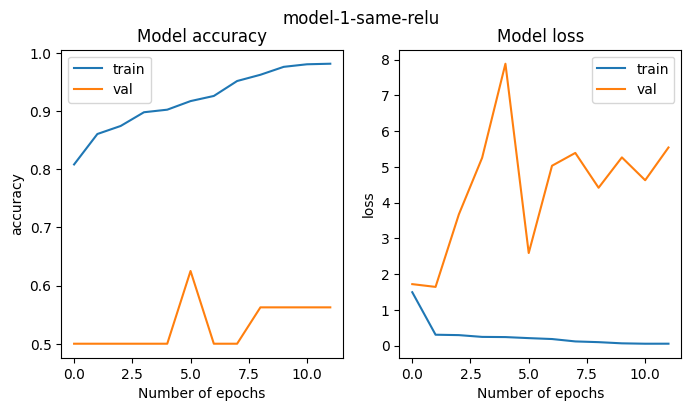

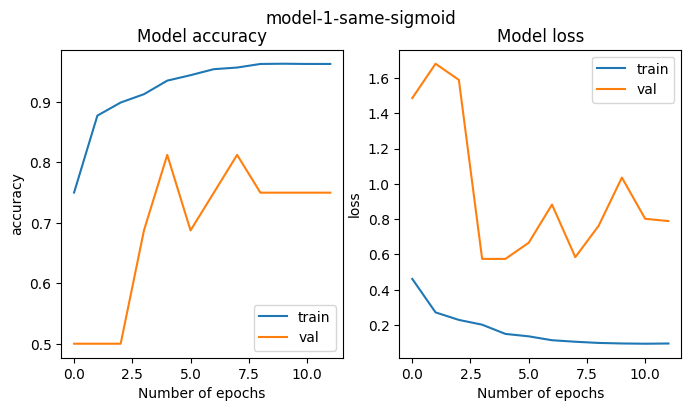

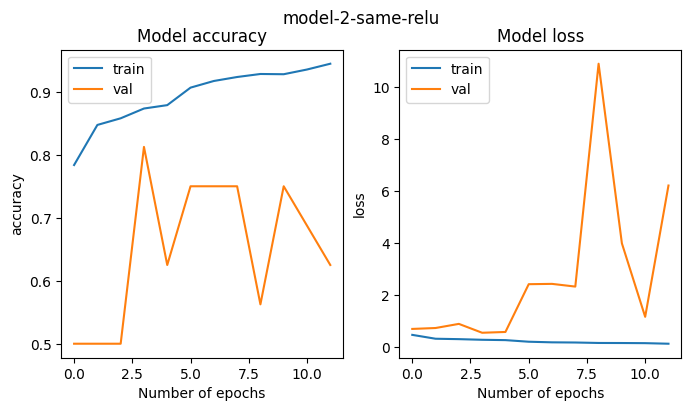

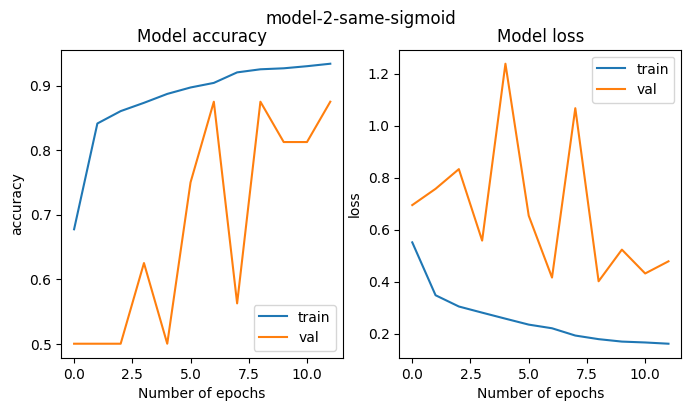

In [ ]:
# Training loop
from itertools import product

# Train all combinations
for stride, padding, activation in product(stride_set, padding_set, activation_set):
    train_model(model_shape, stride, padding, activation)

# Print results
print("\nModel Accuracies:")
print(dict(sorted(models_accuracy.items(), key=lambda item: item[1], reverse=True)))

In [ ]:
# Sort models by accuracy
sorted_models = dict(sorted(models_accuracy.items(), key=lambda item: item[1], reverse=True))

# Print sorted results
print("Model Performance (Sorted by Accuracy):")
for model, accuracy in sorted_models.items():
    print(f"{model}: {accuracy:.4f}")


Model Performance (Sorted by Accuracy):
model-1-same-relu: 0.9803
model-1-same-sigmoid: 0.9630
model-2-same-relu: 0.9446
model-2-same-sigmoid: 0.9339


Top 3 models are model-1-same-relu
model-1-same-sigmoid
model-2-same-relu

We will futher test on these 3 models with test dataset

Test dataset

In [ ]:
# Test dataset preparation
test_dataset = image_dataset_from_directory(test_data_path,
        color_mode='grayscale',
        batch_size=batch_size,
        image_size=(image_size,image_size),
        shuffle=False,
        )
test_dataset = preprocess_dataset(test_dataset, rescaling)

Found 624 files belonging to 2 classes.


In [ ]:
def evaluate_model(model_name):
    print(f"\nEvaluating {model_name}")
    model = load_trained_model(model_name)

    y_pred = []
    y_true = []

    for image_batch, label_batch in test_dataset:
        y_true.append(label_batch)
        preds = model.predict(image_batch)
        y_pred.append(np.round(preds))

    y_pred = tf.concat(y_pred, axis=0)
    y_true = tf.concat(y_true, axis=0)

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    plt.figure(figsize=(8, 6))
    cmd = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
    cmd.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # Print Metric
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = tp / (tp + fp) * 100
    recall = tp / (tp + fn) * 100
    f1 = 2 * precision * recall / (precision + recall)

    print('\nTest Metrics:')
    print(f'Accuracy: {accuracy:.2f}%')
    print(f'Precision: {precision:.2f}%')
    print(f'Recall: {recall:.2f}%')
    print(f'F1-score: {f1:.2f}')

    print('\nClassification Report:')
    print(classification_report(y_true, y_pred, target_names=['Normal (Class 0)', 'Pneumonia (Class 1)']))

    return accuracy, precision, recall, f1

Evaluate top 3 models


Evaluating model-1-same-relu
Loading model-1-same-relu


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d (SeparableConv2D)   │ (None, 128, 128, 64)        │           2,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_1 (SeparableConv2D) │ (None, 64, 64, 128)         │           8,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_2 (SeparableConv2D) │ (None, 32, 32, 256)         │          34,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      33,554,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,335,748 (256.87 MB)

 Trainable params: 33,667,425 (128.43 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 33,667,427 (128.43 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


<Figure size 800x600 with 0 Axes>

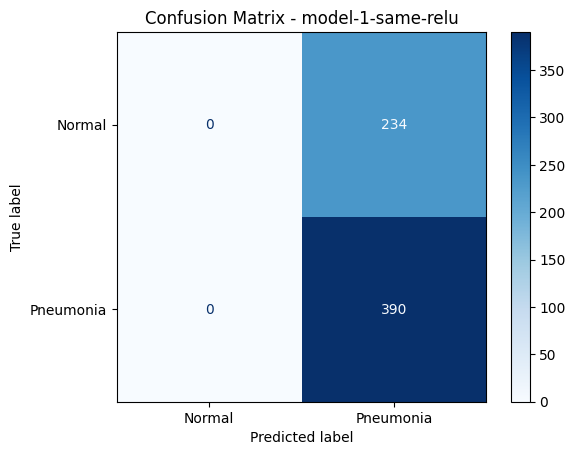


Test Metrics:
Accuracy: 62.50%
Precision: 62.50%
Recall: 100.00%
F1-score: 76.92

Classification Report:
                     precision    recall  f1-score   support

   Normal (Class 0)       0.00      0.00      0.00       234
Pneumonia (Class 1)       0.62      1.00      0.77       390

           accuracy                           0.62       624
          macro avg       0.31      0.50      0.38       624
       weighted avg       0.39      0.62      0.48       624


Evaluating model-1-same-sigmoid
Loading model-1-same-sigmoid


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_3 (SeparableConv2D) │ (None, 128, 128, 64)        │           2,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_4 (SeparableConv2D) │ (None, 64, 64, 128)         │           8,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_5 (SeparableConv2D) │ (None, 32, 32, 256)         │          34,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │      33,554,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,335,748 (256.87 MB)

 Trainable params: 33,667,425 (128.43 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 33,667,427 (128.43 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


<Figure size 800x600 with 0 Axes>

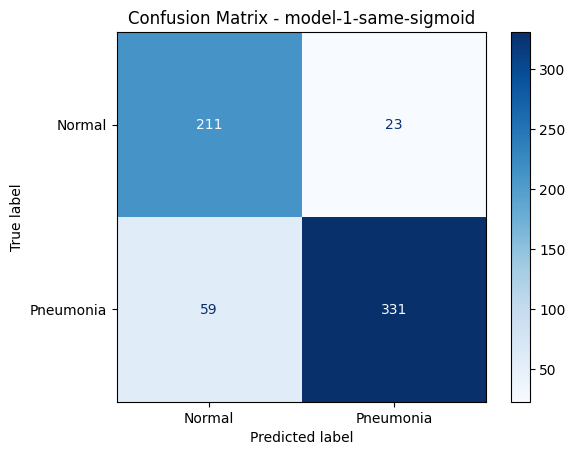


Test Metrics:
Accuracy: 86.86%
Precision: 93.50%
Recall: 84.87%
F1-score: 88.98

Classification Report:
                     precision    recall  f1-score   support

   Normal (Class 0)       0.78      0.90      0.84       234
Pneumonia (Class 1)       0.94      0.85      0.89       390

           accuracy                           0.87       624
          macro avg       0.86      0.88      0.86       624
       weighted avg       0.88      0.87      0.87       624


Evaluating model-2-same-relu
Loading model-2-same-relu


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 256, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_6 (SeparableConv2D) │ (None, 64, 64, 64)          │           2,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_7 (SeparableConv2D) │ (None, 16, 16, 128)         │           8,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_8 (SeparableConv2D) │ (None, 4, 4, 256)           │          34,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,275,460 (4.87 MB)

 Trainable params: 637,281 (2.43 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 637,283 (2.43 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


<Figure size 800x600 with 0 Axes>

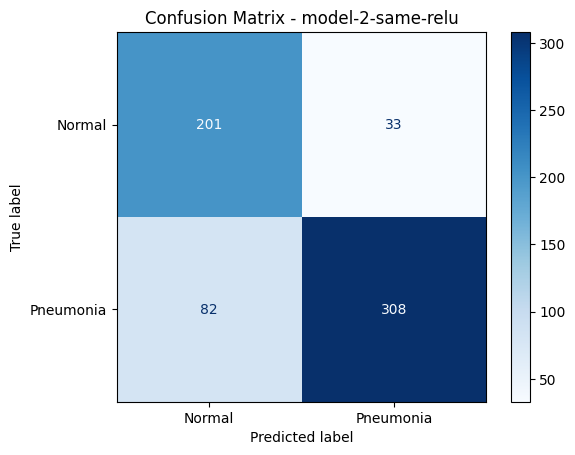


Test Metrics:
Accuracy: 81.57%
Precision: 90.32%
Recall: 78.97%
F1-score: 84.27

Classification Report:
                     precision    recall  f1-score   support

   Normal (Class 0)       0.71      0.86      0.78       234
Pneumonia (Class 1)       0.90      0.79      0.84       390

           accuracy                           0.82       624
          macro avg       0.81      0.82      0.81       624
       weighted avg       0.83      0.82      0.82       624



In [ ]:
# Evaluate top 3 models
top_models = [
    'model-1-same-relu',
    'model-1-same-sigmoid',
    'model-2-same-relu'
]

results = []
for model_name in top_models:
    accuracy, precision, recall, f1 = evaluate_model(model_name)
    results.append({
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

Compare results

In [ ]:
# Compare results
print("\nModel Comparison Summary:")
for result in results:
    print(f"\n{result['model']}:")
    print(f"Accuracy: {result['accuracy']:.2f}%")
    print(f"Precision: {result['precision']:.2f}%")
    print(f"Recall: {result['recall']:.2f}%")
    print(f"F1-score: {result['f1']:.2f}")



Model Comparison Summary:

model-1-same-relu:
Accuracy: 62.50%
Precision: 62.50%
Recall: 100.00%
F1-score: 76.92

model-1-same-sigmoid:
Accuracy: 86.86%
Precision: 93.50%
Recall: 84.87%
F1-score: 88.98

model-2-same-relu:
Accuracy: 81.57%
Precision: 90.32%
Recall: 78.97%
F1-score: 84.27
